# Cheminformatics in Python: Predicting Boiling Point of Molecules
Hannah Winter

Inspiration of this project comes from Chanin Nantasenamat and his recreation of Delaneys work predicting molecules solubility. Boiling points in the exercise came from:https://www.engineeringtoolbox.com/boiling-points-fluids-gases-d_155.html, with some more abiguous inclusions removed.

### Part One: Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem 
from urllib.request import urlopen
import sys
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Part Two: Dowload and Clean data

In [2]:
basedata = pd.read_csv('boiling_points.csv', encoding= 'unicode_escape')
#Converting molecule name to SMILES
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + ids + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return np.nan
#Replace spaces with %20 for http accuracy
basedata['Compound'] = basedata['Compound'].replace(' ', '%20', regex=True)

#apply coversion and save, as processing time is long  
# basedata['SMILES'] = basedata['Compound'].apply(CIRconvert)
# basedata.to_csv('shortcut.csv')

In [3]:
bp = pd.read_csv('shortcut.csv', index_col=0)
bp_drop = bp.dropna().reset_index()
bp_drop

,index,Compound,boiling point,SMILES
0,0,Acetaldehyde,20.80,CC=O
1,1,Acetic%20acid%20anhydride,139.00,CC(=O)OC(C)=O
2,2,Acetone,56.08,CC(C)=O
3,4,Acetylene,-84.00,C#C
4,5,Acrolein,52.30,C=CC=O
...,...,...,...,...
128,147,Triethanolamine,350.00,OCCN(CCO)CCO
129,149,Water,100.00,O
130,150,o-Xylene,144.40,Cc1ccccc1C
131,151,m-Xylene,139.10,Cc1cccc(C)c1


### Part 3: Explore with RDKit

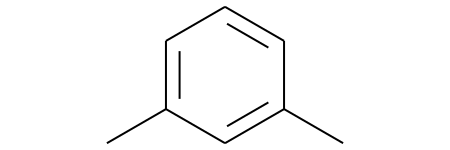

In [4]:
#test a making an RDKit object from SMILES
m = Chem.MolFromSmiles(bp_drop.SMILES[131])
m

In [5]:
m.GetNumAtoms()

8

In [6]:
#Get molecular weight
molwt = Descriptors.MolWt(m)
molwt

106.16799999999999

In [7]:
#Calculate inter-molecular forces
#hydrogen bonds:
def count_hbonds(m):
    deg_hbond = 0
    for i in range(m.GetNumAtoms()):
        if m.GetAtomWithIdx(i).GetMass() == 18.998: 
            if m.GetAtomWithIdx(i).GetNumImplicitHs() >=1: deg_hbond += 2
        if m.GetAtomWithIdx(i).GetMass() == 15.999: 
            if m.GetAtomWithIdx(i).GetNumImplicitHs() >=1: deg_hbond += 1
        if m.GetAtomWithIdx(i).GetMass() == 14.007: 
            if m.GetAtomWithIdx(i).GetNumImplicitHs() >=1: deg_hbond += 0.5
            
    return deg_hbond

hbonds = count_hbonds(m)
hbonds


0

In [8]:
#Calculate intra-molecular forces:
def intramol(m):
    bond_count = sum([m.GetBondWithIdx(i).GetBondTypeAsDouble() for i in range(m.GetNumBonds())])
    return bond_count 
intra = intramol(m)
intra

11.0

In [9]:
#Calculate molecular descriptors
smiles = []
for element in bp_drop.SMILES:
    mol = Chem.MolFromSmiles(element)
    smiles.append(mol)
    
smiles_molwt = [Descriptors.MolWt(element) for element in smiles]
df= pd.DataFrame(smiles_molwt, columns=['MolecularWgt'])
df['HBonds'] = [count_hbonds(m) for m in smiles]
df['DegBonding'] = [intramol(m) for m in smiles]
len(smiles)

133

### Part 4: Data Analysis

In [10]:
#Assign X and Y sets
X = df
X

,MolecularWgt,HBonds,DegBonding
0,44.053,0.0,3.0
1,102.089,0.0,8.0
2,58.080,0.0,4.0
3,26.038,0.0,3.0
4,56.064,0.0,5.0
...,...,...,...
128,149.190,3.0,9.0
129,18.015,1.0,0.0
130,106.168,0.0,11.0
131,106.168,0.0,11.0


In [11]:
Y = bp_drop.iloc[:,2]
Y

0       20.80
1      139.00
2       56.08
3      -84.00
4       52.30
        ...  
128    350.00
129    100.00
130    144.40
131    139.10
132    138.30
Name: boiling point, Length: 133, dtype: float64

In [12]:
#Data split:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [13]:
#training the model
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
Y_pred_train = model.predict(X_train)

In [15]:
#Results of the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): ' + str(round(mean_squared_error(Y_train, Y_pred_train), 2)))
print('Coefficient of determination (R^2): ' + str(round(r2_score(Y_train, Y_pred_train), 2)))

Coefficients: [ 1.67355829 71.12164437  0.55030705]
Intercept: -90.28514043205139
Mean squared error (MSE): 5703.22
Coefficient of determination (R^2): 0.6


In [16]:
Y_pred_test = model.predict(X_test)

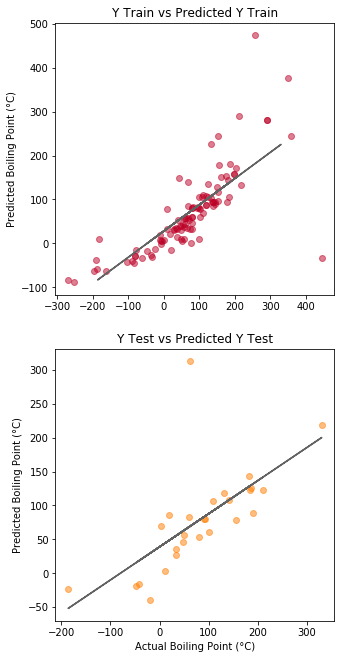

In [17]:
#Plotting the actual vs predicted
plt.figure(figsize=(5,11))

plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#bd0026", alpha=0.5)
# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#636363")
plt.ylabel('Predicted Boiling Point (°C)')
plt.title('Y Train vs Predicted Y Train')

plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#ff7f00", alpha=0.5)
z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#636363")
plt.ylabel('Predicted Boiling Point (°C)')
plt.xlabel('Actual Boiling Point (°C)')
plt.title('Y Test vs Predicted Y Test')

# plt.savefig('plot_actual_vs_predicted.png')
plt.show()

### Part 5: Predicting Molecules Boiling Points

In [21]:
#Using the model to predict unknown boiling point (Tetrachloroethylene = 121.1 °C)
#Convert to SMILE:
unknown = 'Tetrachloroethylene'
unknown_Y = 121.1
unknown_SMILE = CIRconvert(unknown)
unknown_mol = Chem.MolFromSmiles(unknown_SMILE)
#Calculate descriptors:
unknown_molwt = Descriptors.MolWt(unknown_mol)
unknown_HBonds = count_hbonds(unknown_mol)
unknown_DegBonding = intramol(unknown_mol)
unknown_df = pd.DataFrame([[unknown_molwt,unknown_HBonds, unknown_DegBonding]], columns=['MolecularWgt', 'HBonds', 'DegBonding'])
# #Calculate predicted Y:
unknown_predicted_Y = model.predict(unknown_df)
#Compare:
print(unknown)
print('Actual Boiling Point (°C): ' + str(unknown_Y))
print('Predicted Boiling Point (°C)' + str(round(unknown_predicted_Y[0], 2)))

Tetrachloroethylene
Actual Boiling Point (°C): 121.1
Predicted Boiling Point (°C)190.55


In [22]:
#Using the model to predict unknown boiling point (1-Hexanol = 157 °C)
#Convert to SMILE:
unknown2 = '1-Hexanol'
unknown2_Y = 157
unknown2_SMILE = CIRconvert(unknown2)
unknown2_mol = Chem.MolFromSmiles(unknown2_SMILE)
#Calculate descriptors:
unknown2_molwt = Descriptors.MolWt(unknown2_mol)
unknown2_HBonds = count_hbonds(unknown2_mol)
unknown2_DegBonding = intramol(unknown2_mol)
unknown2_df = pd.DataFrame([[unknown2_molwt,unknown2_HBonds, unknown2_DegBonding]], columns=['MolecularWgt', 'HBonds', 'DegBonding'])
# #Calculate predicted Y:
unknown2_predicted_Y = model.predict(unknown2_df)
#Compare:
print(unknown2)
print('Actual Boiling Point (°C): ' + str(unknown2_Y))
print('Predicted Boiling Point (°C)' + str(round(unknown2_predicted_Y[0], 2)))

1-Hexanol
Actual Boiling Point (°C): 157
Predicted Boiling Point (°C)155.14
